# Data Wrangling - Olympics Success Factors Project
- Antón Fidalgo Pérez
- Peter Samuelsen Gabriel
- Samuel Heras de Paz

## What factors influence a country's representation in the Olympics from 1896 to 2016? 

We first will the library **pandas** and will read the file that contains the data set.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows = 20
np.set_printoptions(precision=4, suppress=True)

In [5]:
# open file
file = 'athlete_events.csv'
regions = 'noc_regions.csv'
df = pd.read_csv(file)
noc_regions = pd.read_csv(regions)

Have a look at our data set, the different rows and columns.

In [7]:
display(df)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


## 1. Geographical, Climate and Economic Factors
### 1.1. Does hosting the Olympics increase a country's athlete representation?

To have a good answer to this question, we will focus our work towards the countries that have hosted the olympics the most times. Remeber that the data set we are working with has data from Athens 1896 to Rio 2016. Since we only have data about hosting city and not hosting country, we will create a mapping city to country first.

In [10]:
summer_olympics = df[df['Season'] == 'Summer'].copy()
city_to_country = {
    'Athens': 'Greece',
    'Paris': 'France',
    'St. Louis': 'United States',
    'London': 'United Kingdom',
    'Stockholm': 'Sweden',
    'Antwerpen': 'Belgium',
    'Amsterdam': 'Netherlands',
    'Los Angeles': 'United States',
    'Berlin': 'Germany',
    'Helsinki': 'Finland',
    'Melbourne': 'Australia',
    'Rome': 'Italy',
    'Tokyo': 'Japan',
    'Mexico City': 'Mexico',
    'Munich': 'Germany',
    'Montreal': 'Canada',
    'Moscow': 'Russia',
    'Seoul': 'South Korea',
    'Barcelona': 'Spain',
    'Atlanta': 'United States',
    'Sydney': 'Australia',
    'Beijing': 'China',
    'Rio de Janeiro': 'Brazil',
}
summer_olympics['Country'] = summer_olympics['City'].map(city_to_country)
unique_games_by_country = summer_olympics[['Country', 'Games']].drop_duplicates()
hosted_olympics = unique_games_by_country.groupby('Country')['Games'].agg(['count', list]).reset_index()
countries_list = hosted_olympics[hosted_olympics['count'] > 2]
countries_list.columns = ['Country', 'Total Hosted', 'Games Hosted']
print(countries_list)


           Country  Total Hosted  \
14  United Kingdom             3   
15   United States             4   

                                         Games Hosted  
14            [2012 Summer, 1948 Summer, 1908 Summer]  
15  [1932 Summer, 1996 Summer, 1984 Summer, 1904 S...  


As we can see, only the United Stated and the United Kingdom have hosted more than two times the Olympics within the time frame, four and three times respectively. For the United Kinkgdom, that was 2012, 1948 and 1908; for the United States, that was 1932, 1996, 1984 and 1904. Hence, we are going to focus on those two countries.

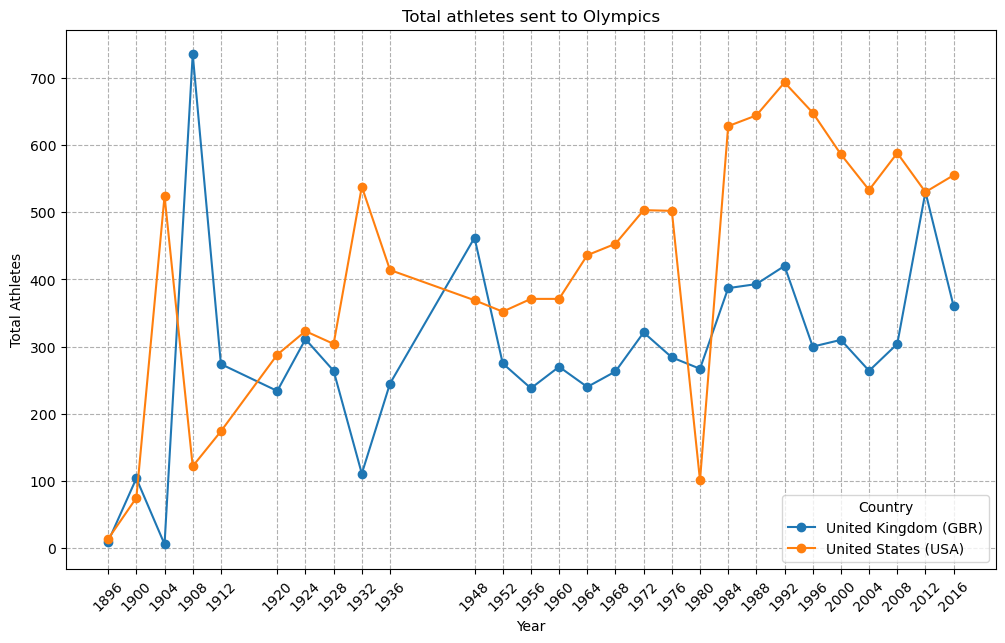

In [32]:
merged_data = pd.merge(df, noc_regions, on='NOC', how='left')
us_uk_data = merged_data[merged_data['NOC'].isin(['USA', 'GBR'])]
athlete_counts = (us_uk_data.groupby(['Year', 'NOC'])['ID'].nunique().reset_index().rename(columns={'ID': 'Total Athletes'}))

olympic_years = athlete_counts['Year'].unique()
olympic_years = sorted(year for year in olympic_years if year % 4 == 0)
athlete_counts_pivot = (athlete_counts.pivot(index='Year', columns='NOC', values='Total Athletes').reindex(olympic_years))

# Plot 
plt.figure(figsize=(12, 7))
athlete_counts_pivot.plot(kind='line', marker='o', ax=plt.gca())
plt.title('Total athletes sent to Olympics')
plt.xlabel('Year')
plt.ylabel('Total Athletes')
plt.legend(title='Country', labels=['United Kingdom (GBR)', 'United States (USA)'])
plt.grid(True, linestyle='--')
plt.xticks(ticks=athlete_counts_pivot.index, rotation=45)  # Olympic years only
plt.show()

As we can see, for both teams it is true that when the Olympic Games where hosted home, the team would send more athletes with respect to previous years.

### 1.2. Does having a similar climate to the host country have any significant impact on representation in outdoor sports?